<a href="https://colab.research.google.com/github/deval025/LHD-build-automate-a-daily-task-activity/blob/main/Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!pip install imbalanced-learn --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#libraries
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import KFold, cross_val_score

In [ ]:
# reading the CSV file
df = pd.read_csv('/content/gdrive/MyDrive/fraud_detection/Fraud.csv')
print(df.head())
print(df.describe().T)
df.shape
print(df.info())

   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  
                    count          mean           std  min       25%  \
step            6362620.0  2.4339

In [ ]:
print("Mean feature values per category",df.groupby('type')['amount','isFraud','isFlaggedFraud'].mean())

<ipython-input-10-6eb6947633ce>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  print("Mean feature values per category",df.groupby('type')['amount','isFraud','isFlaggedFraud'].mean())


Mean feature values per category                  amount   isFraud  isFlaggedFraud
type                                             
CASH_IN   168920.242004  0.000000         0.00000
CASH_OUT  176273.964346  0.001840         0.00000
DEBIT       5483.665314  0.000000         0.00000
PAYMENT    13057.604660  0.000000         0.00000
TRANSFER  910647.009645  0.007688         0.00003


# observations
-oldbalanceDest and newbalanceDest have no information for nameDest with "M" in the name i.e merchants.
-there is need for encoding in nameOrig, nameDest, and type.
-

In [ ]:
df['isFraud'].value_counts()
df['amount'].max()

92445516.64

0             9839.64
1             1864.28
2              181.00
3              181.00
4            11668.14
              ...    
6362615     339682.13
6362616    6311409.28
6362617    6311409.28
6362618     850002.52
6362619     850002.52
Name: amount, Length: 6362620, dtype: float64


Text(0.5, 0, 'Amount')

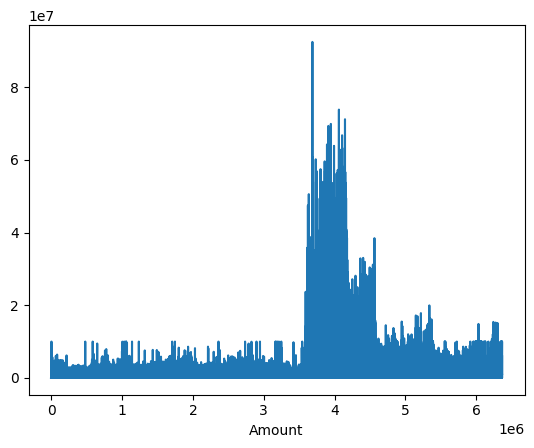

In [ ]:
print(df["amount"])
df['amount'].plot()
plt.xlabel('Amount')

Text(0.5, 0, 'Amount')

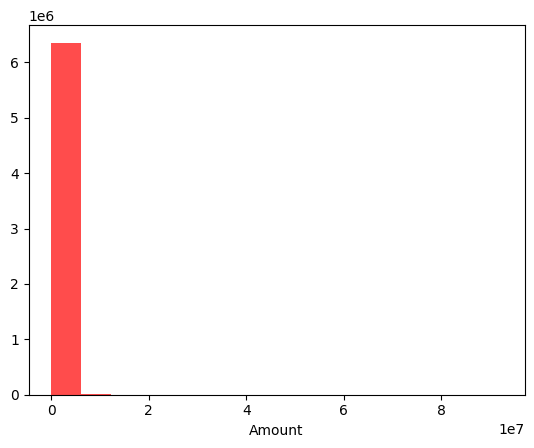

In [ ]:
plt.hist(df['amount'],bins=15,color='r',alpha=0.7)
plt.xlabel('Amount')

Text(0.5, 0, 'Scaled Amount')

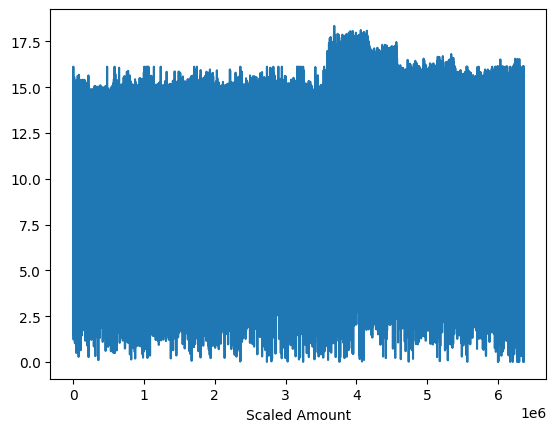

In [ ]:
df['scaled_Amount'] = np.log1p(df['amount'])
df['scaled_Amount'].plot()
plt.xlabel('Scaled Amount')

In [ ]:
print('MIN Amount: ',df['scaled_Amount'].min())
print('MAX Amount: ',df['scaled_Amount'].max())
df['scaled_Amount']

MIN Amount:  0.0
MAX Amount:  18.342130030468418


0           9.194276
1           7.531166
2           5.204007
3           5.204007
4           9.364703
             ...    
6362615    12.735768
6362616    15.657870
6362617    15.657870
6362618    13.652996
6362619    13.652996
Name: scaled_Amount, Length: 6362620, dtype: float64

Text(0.5, 0, 'time(in hrs)')

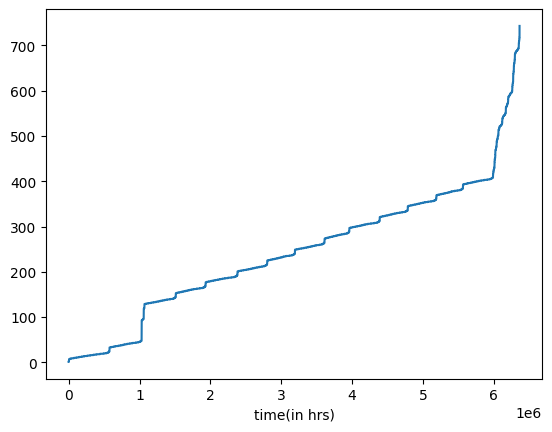

In [ ]:
df['step'].plot()
#consistent and valid time values
plt.xlabel('time(in hrs)')

In [ ]:
import plotly.graph_objects as go

In [ ]:
colors = ['white', '#d1364e']  
labels = ['Normal','Fraud'] 
values = df['isFraud'].value_counts()/df['isFraud'].shape[0]
fig = go.Figure(data=[go.Pie(labels = labels,
                             values=values,hole=.3)])
fig.update_traces(hoverinfo='label+percent', textinfo='percent', textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='white', width=0.1)))
fig.update_layout(
    title_text="Credit Card Fraud",
    title_font_color="white",
    paper_bgcolor="green",
    plot_bgcolor='green',
    font_color="white",
)
fig.show()

<ipython-input-19-4d4720c58118>:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



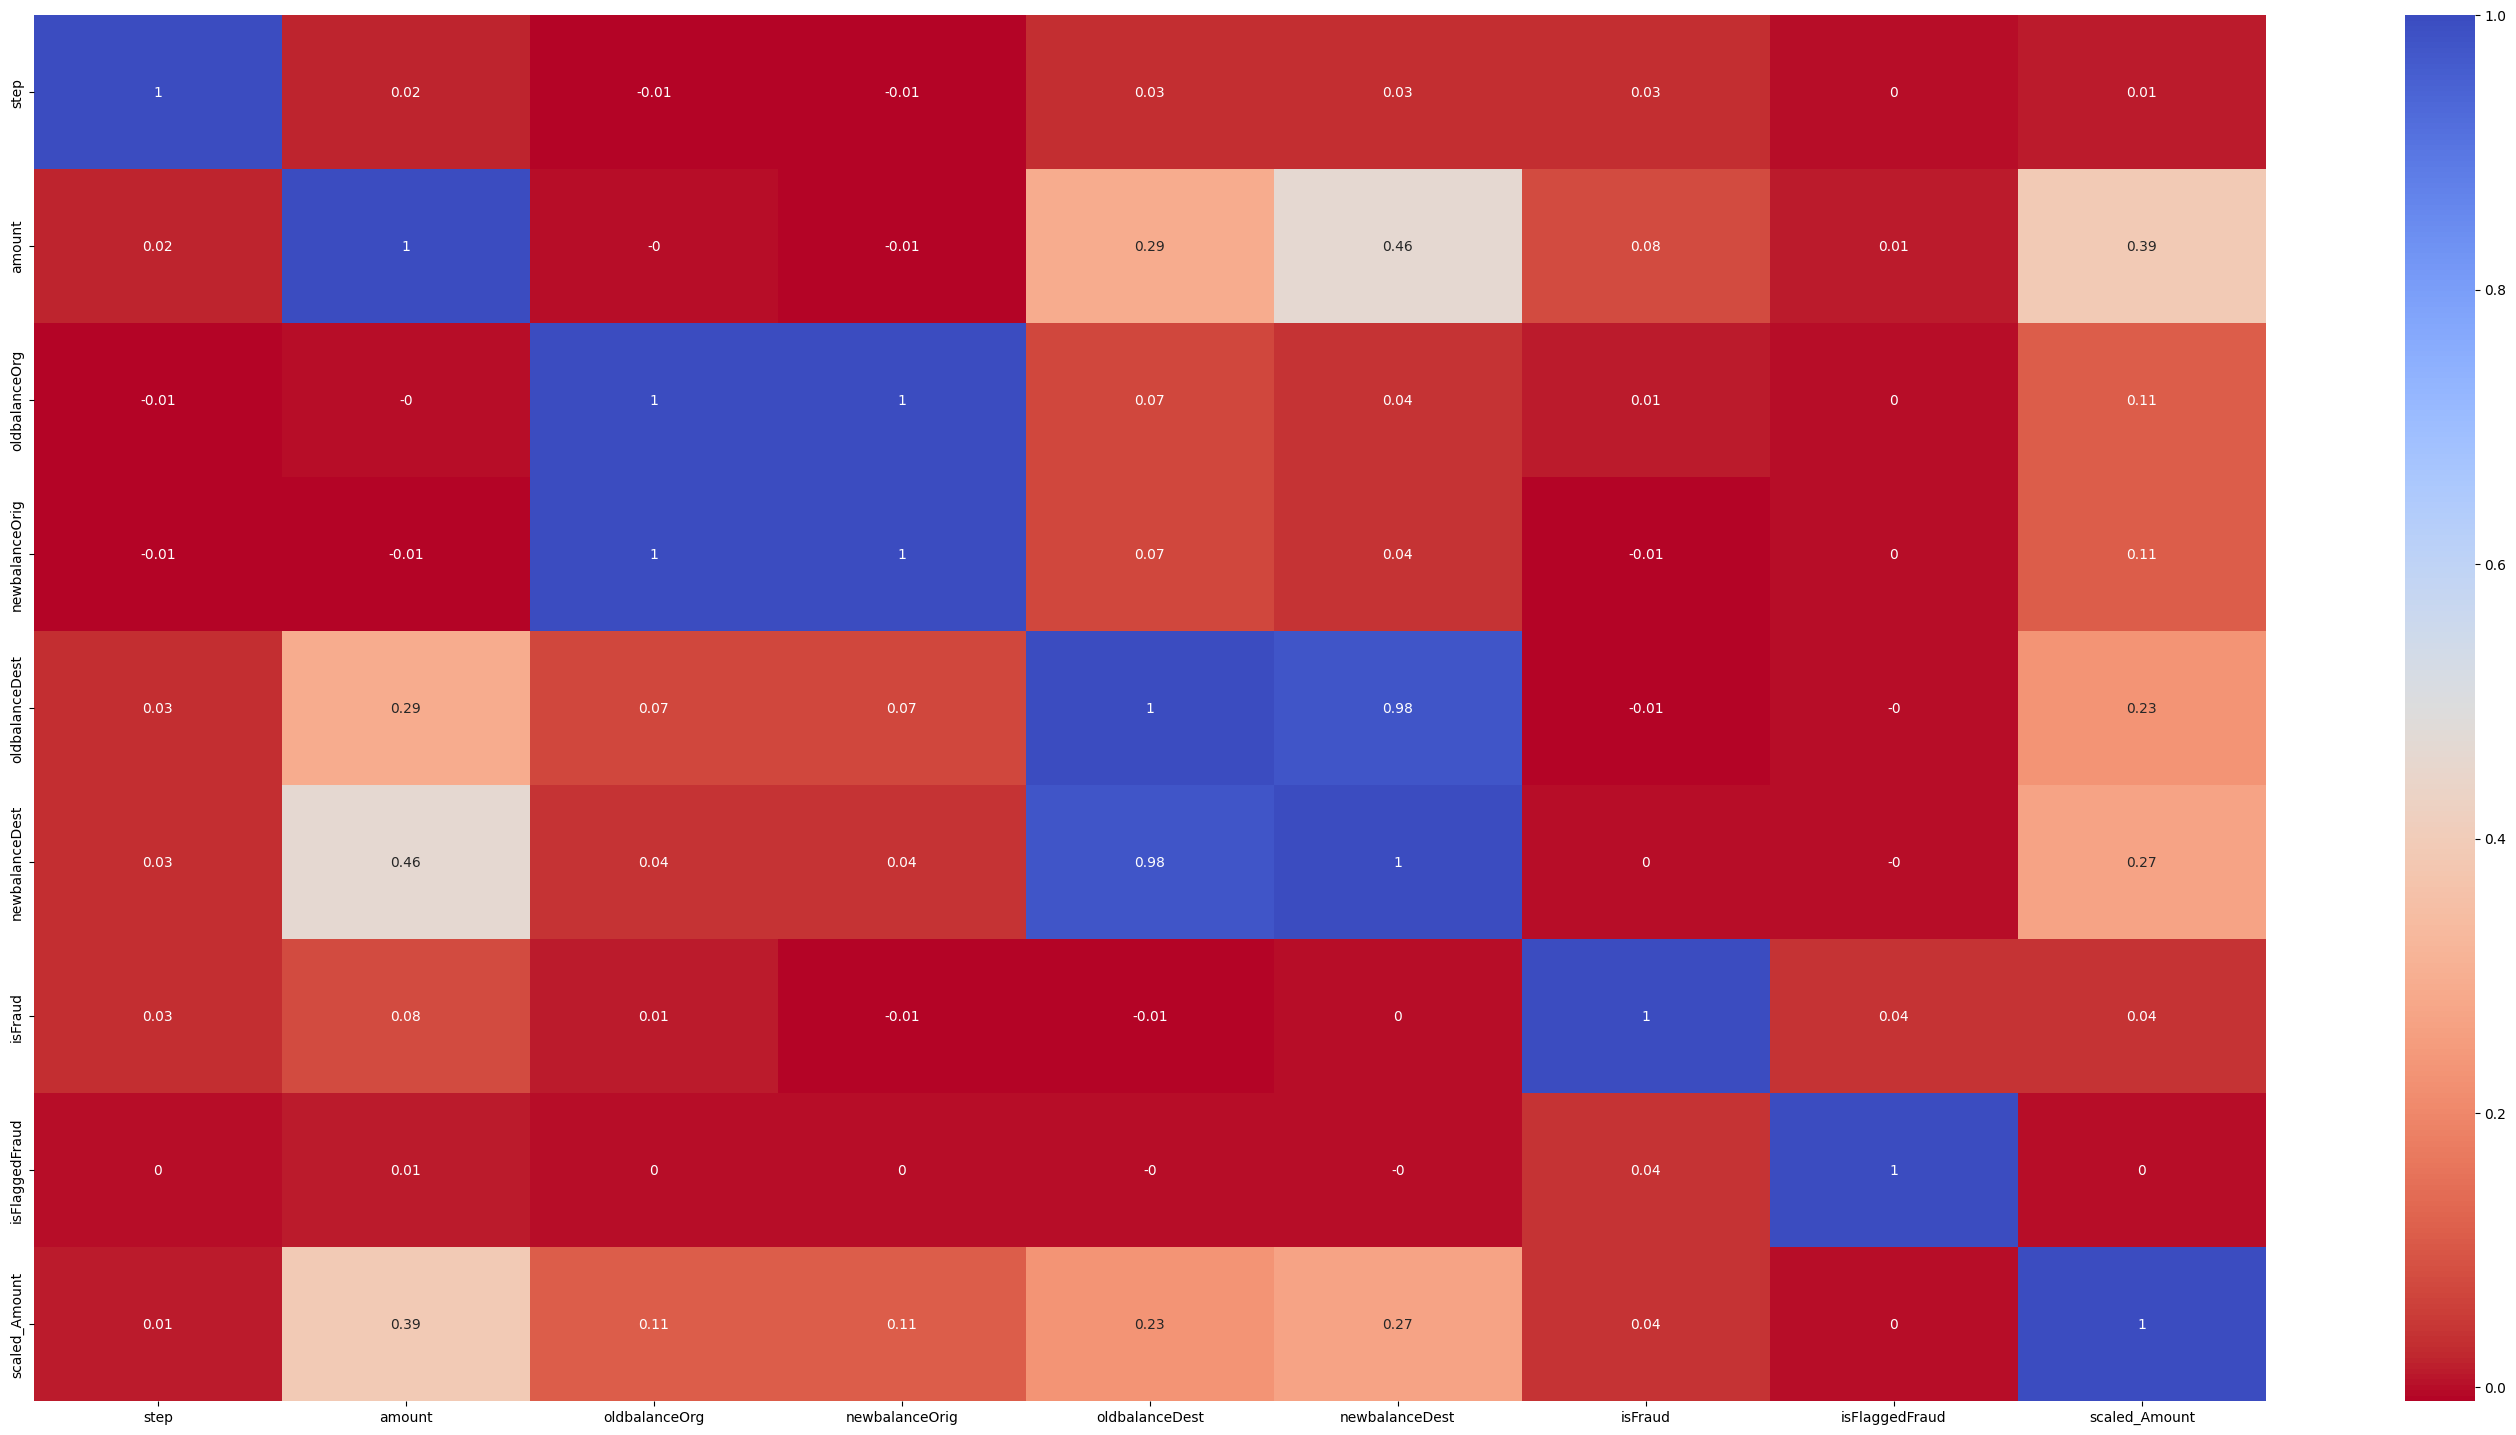

In [ ]:
correlation_matrix = round(df.corr(),2)
plt.figure(figsize=(36,18))
sns.heatmap(correlation_matrix,cmap='coolwarm_r', annot=True)
plt.show()

In [ ]:
# turning object columns type to categorical for easing the transformation process
col_categorical = df.select_dtypes(include= ['object']).columns
for col in col_categorical:
    df[col] = df[col].astype('category')
# categorical values ==> numeric values
df[col_categorical] = df[col_categorical].apply(lambda x: x.cat.codes)
df.head(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,scaled_Amount
0,1,3,9839.64,757869,170136.0,160296.36,1662094,0.0,0.0,0,0,9.194276
1,1,3,1864.28,2188998,21249.0,19384.72,1733924,0.0,0.0,0,0,7.531166
2,1,4,181.00,1002156,181.0,0.00,439685,0.0,0.0,1,0,5.204007
3,1,1,181.00,5828262,181.0,0.00,391696,21182.0,0.0,1,0,5.204007
4,1,3,11668.14,3445981,41554.0,29885.86,828919,0.0,0.0,0,0,9.364703


In [ ]:
X = df.drop(['isFraud'],axis=1)
y = df['isFraud']
print(X.head(),"\n")
print(y.head())

   step  type    amount  nameOrig  oldbalanceOrg  newbalanceOrig  nameDest  \
0     1     3   9839.64    757869       170136.0       160296.36   1662094   
1     1     3   1864.28   2188998        21249.0        19384.72   1733924   
2     1     4    181.00   1002156          181.0            0.00    439685   
3     1     1    181.00   5828262          181.0            0.00    391696   
4     1     3  11668.14   3445981        41554.0        29885.86    828919   

   oldbalanceDest  newbalanceDest  isFlaggedFraud  scaled_Amount  
0             0.0             0.0               0       9.194276  
1             0.0             0.0               0       7.531166  
2             0.0             0.0               0       5.204007  
3         21182.0             0.0               0       5.204007  
4             0.0             0.0               0       9.364703   

0    0
1    0
2    1
3    1
4    0
Name: isFraud, dtype: int64


In [ ]:
y[y==1].count()

8213

#My Smote and training

In [ ]:
X = df.drop(['isFraud'],axis=1)
y = df.isFraud

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25,random_state=24)

In [ ]:
#oversampling training data   
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=24)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

print(X_smote.shape)
print(y_smote.shape)

(9531470, 11)
(9531470,)


In [ ]:
colors = ['white', '#d1364e']  
labels = ['Normal','Fraud'] 
values = y_smote.value_counts()/y_smote.shape[0]
fig = go.Figure(data=[go.Pie(labels = labels,
                             values=values,hole=.3)])
fig.update_traces(hoverinfo='label+percent', textinfo='percent', textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='white', width=0.1)))
fig.update_layout(
    title_text="Credit Card Fraud",
    title_font_color="white",
    paper_bgcolor="green",
    plot_bgcolor='green',
    font_color="white",
)
fig.show()

##Random Forest

In [ ]:
rf = RandomForestClassifier()
rf.fit(X_smote, y_smote)

RandomForestClassifier()

In [ ]:
y_pred2 = rf.predict(X_test)
report2 = classification_report(y_pred2, y_test)
print(report2)
print(f"Accuracy: {accuracy_score(y_pred2, y_test)}")
print(f"ROC AUC Score for Random Forest Classifier: {roc_auc_score(y_pred2, y_test)}")

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1588005
           1       0.96      0.72      0.82      2650

    accuracy                           1.00   1590655
   macro avg       0.98      0.86      0.91   1590655
weighted avg       1.00      1.00      1.00   1590655

Accuracy: 0.9994775737039144
ROC AUC Score for Random Forest Classifier: 0.8586534267245131


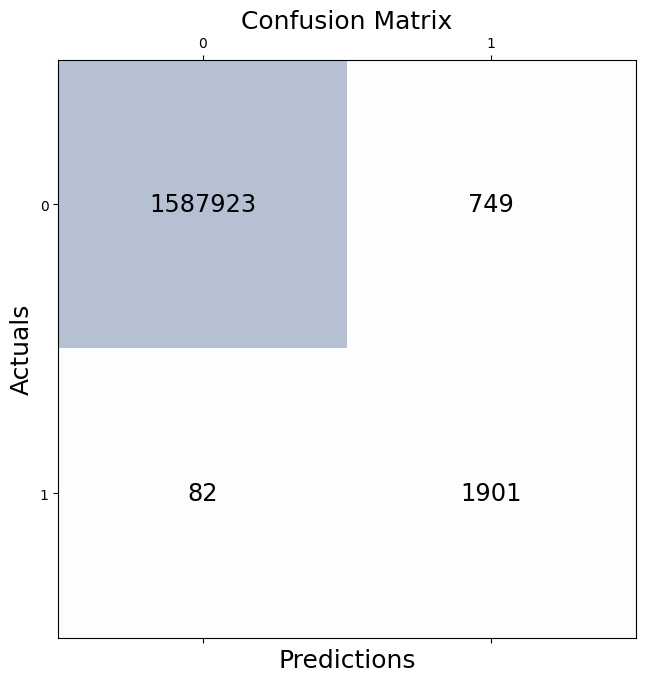

In [ ]:
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred2)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()